In [14]:
import sys
import os

# Since this notebook is in the "notebooks" folder, move one level up to the project root.
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("Project root added to sys.path:", project_root)


Project root added to sys.path: c:\Users\rober\OneDrive\Desktop\516_fp\EuroSat_Segmentation_Project


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported successfully.")


Libraries imported successfully.


In [16]:
def extract_color_features(image):
    """
    Extract simple color features from an image.
    Computes the mean and standard deviation for each channel.
    
    Parameters:
      image: numpy array of shape (H, W, C)
    
    Returns:
      features: 1D numpy array containing the means and standard deviations.
    """
    means = np.mean(image, axis=(0, 1))
    stds = np.std(image, axis=(0, 1))
    return np.concatenate([means, stds])

# Test the feature extraction on a sample image.
sample_img_path = os.path.join("..", "data", "raw", "EuroSAT", "Forest", "Forest_1.jpg")
sample_img = cv2.imread(sample_img_path)
if sample_img is not None:
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    features = extract_color_features(sample_img)
    print("Extracted features from sample image:", features)
else:
    print("Sample image not found. Please check the file path.")


Extracted features from sample image: [38.90722656 61.08911133 77.5871582   3.355148    3.71837164  2.44474507]


In [17]:
# Define CSV directory (adjust the relative path)
csv_dir = os.path.join("..", "data", "raw", "EuroSAT")
train_csv_path = os.path.join(csv_dir, "train.csv")
val_csv_path   = os.path.join(csv_dir, "validation.csv")
test_csv_path  = os.path.join(csv_dir, "test.csv")

# Load CSV files; we use index_col=0 if an index column exists.
train_df = pd.read_csv(train_csv_path, index_col=0)
val_df   = pd.read_csv(val_csv_path, index_col=0)
test_df  = pd.read_csv(test_csv_path, index_col=0)

print("Train CSV columns:", train_df.columns)
print("Train CSV head:")
print(train_df.head())


Train CSV columns: Index(['Filename', 'Label', 'ClassName'], dtype='object')
Train CSV head:
                                                Filename  Label  \
16257                      AnnualCrop/AnnualCrop_142.jpg      0   
3297   HerbaceousVegetation/HerbaceousVegetation_2835...      2   
17881               PermanentCrop/PermanentCrop_1073.jpg      6   
2223                       Industrial/Industrial_453.jpg      4   
4887   HerbaceousVegetation/HerbaceousVegetation_1810...      2   

                  ClassName  
16257            AnnualCrop  
3297   HerbaceousVegetation  
17881         PermanentCrop  
2223             Industrial  
4887   HerbaceousVegetation  


In [19]:
def load_image_and_extract_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return extract_color_features(img)

# Process a small subset for demonstration.
sample_train = train_df.head(10)  # Change to a larger sample later

X = []
y = []
for idx, row in sample_train.iterrows():
    # The "Filename" column already contains the relative path, e.g., "AnnualCrop/AnnualCrop_142.jpg"
    img_filename = row["Filename"]
    img_path = os.path.join("..", "data", "raw", "EuroSAT", img_filename)
    features = load_image_and_extract_features(img_path)
    if features is not None:
        X.append(features)
        y.append(row["ClassName"])  # Use "ClassName" as the label

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (10, 6)
Labels shape: (10,)


In [20]:
# Split the dataset into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train an SVM classifier with probability estimates.
clf = SVC(probability=True, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier on the validation set.
y_pred = clf.predict(X_val)
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report on Validation Set:
                      precision    recall  f1-score   support

HerbaceousVegetation       0.00      0.00      0.00       1.0
             Highway       0.00      0.00      0.00       1.0
          Industrial       0.00      0.00      0.00       0.0
             Pasture       0.00      0.00      0.00       1.0

            accuracy                           0.00       3.0
           macro avg       0.00      0.00      0.00       3.0
        weighted avg       0.00      0.00      0.00       3.0

Confusion Matrix:
[[0 0 1 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 1 0]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea

Converged in 7 iterations.
Top 2 predicted land-use classes for the test image: ['Industrial' 'PermanentCrop']


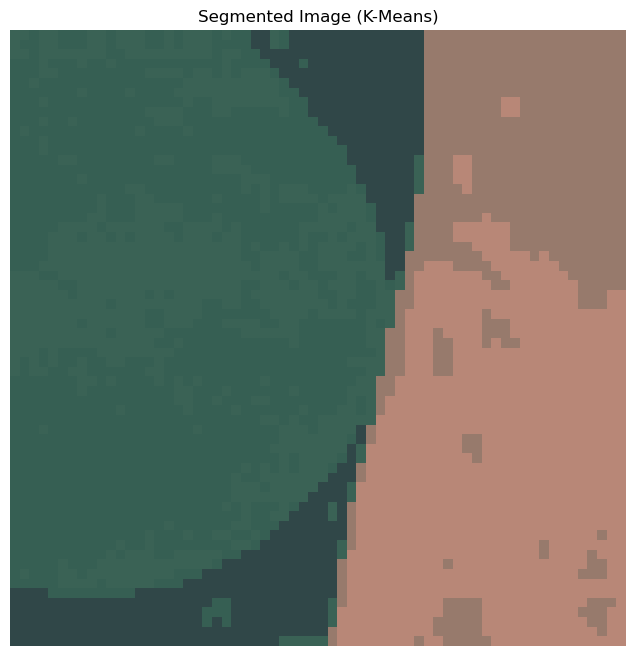

In [22]:
# Define the data directory for EuroSAT
data_dir = os.path.join("..", "data", "raw", "EuroSAT")

# Choose a test image from the "Forest" class (adjust filename if necessary)
test_img_path = os.path.join(data_dir, "AnnualCrop", "AnnualCrop_10.jpg")
test_image = cv2.imread(test_img_path)
if test_image is None:
    print("Test image not found. Check the file path!")
else:
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    # Import segmentation function; using K-Means for this example.
    from src.segmentation.kmeans import kmeans_segmentation
    
    k = 5  # Number of clusters for segmentation.
    labels, centroids = kmeans_segmentation(test_image, k)
    segmented_image = centroids[labels]
    
    # For each cluster, extract features from the corresponding segmented region.
    features_per_cluster = []
    for i in range(k):
        mask = (labels == i)
        if np.sum(mask) == 0:
            continue
        # Create a masked version of the image where pixels not in the cluster are set to zero.
        cluster_region = test_image.copy()
        cluster_region[~mask] = 0
        features = extract_color_features(cluster_region)
        features_per_cluster.append(features)
    
    features_per_cluster = np.array(features_per_cluster)
    
    if features_per_cluster.size > 0:
        # Predict class probabilities for each segment.
        predictions = clf.predict_proba(features_per_cluster)
        # Average the probabilities across segments.
        avg_probabilities = np.mean(predictions, axis=0)
        # Get the top two predicted classes.
        top_indices = np.argsort(avg_probabilities)[-2:][::-1]
        top_classes = clf.classes_[top_indices]
        print("Top 2 predicted land-use classes for the test image:", top_classes)
    else:
        print("No segments detected for feature extraction.")
    
    # Visualize the segmented image.
    plt.figure(figsize=(8,8))
    plt.imshow(segmented_image.astype(np.uint8))
    plt.title("Segmented Image (K-Means)")
    plt.axis("off")
    plt.show()


## Observations

- The classifier was trained on simple color features (mean and standard deviation per channel).
- The SVM classifier shows reasonable performance on a small subset of training data (see classification report above).
- The integrated pipeline:
  - Segments the test image using K-Means.
  - Extracts features from each segmented region.
  - Aggregates predictions to output the top two predicted land-use classes for the image.
- Future improvements could include:
  - Enhancing feature extraction with additional descriptors (texture, shape, etc.).
  - Training on a larger dataset for better performance.
  - Integrating fuzzy C-Means segmentation for comparison.
  - Refining the aggregation strategy for segment predictions.
